# Bonus Questions

<div class="alert alert-warning">
<h3>Goal of These Tasks:</h3>

The following tasks are aimed to widen your scope in implementing an A/B test. The insight gained from this exercise will help you understand the importance of the following aspects of an A/B test:

- Probability of making an error and the subsequent impact on the conversion rate
- The number of samples required to run an A/B test. Or the duration for which the A/B test should be run
 
</div>

Consider a scenario where you have implemented an A/B test with the following specifications:

- You assumed a Beta(1,1) as the prior for both variants.
- You have 10 samples and 2 conversions for variant A.
- You have 10 samples and 3 conversions for variant B.
- You have obtained the posterior distributions of conversion rates for both variants.
- For simplicity assume that N_A = N_B.

You decide to stop the test and declare B as the winner. However, you are not sure if you have made the right decision. So, you decide to run a few checks to see if you have made the right decision. You find out that:

- About two third of times variant B happen to be better than variant A.
- There is an about 4% loss in conversion rate by choosing variant B over variant A.

<div class="alert alert-info">
<h4>Task 1</h4>

Your task is to develop solution methods that give you the above mentioned quantities using three different methods:

1. Closed form solution
2. Numerical approximation
3. Simulation i.e. based on the outcomes from PyMC
</div>

<div class="alert alert-info">
<h4>Task 2</h4>

You realize that the 4% loss in conversion rate is not acceptable. So, you decide to collect more samples. But at some point you have to stop the test. You decide to stop the test when the loss in conversion rate drops below 1%. How many more samples you need to collect to drop the loss to less than 1%? 

</div>


<div class="alert alert-success">

Hint: given $\theta_A \sim \beta(a_1,b_1)$ and $\theta_B \sim \beta(a_2,b_2)$ as posterior distributions for the conversion rates of variants A and B, we can show that:

\begin{align*}
P(\theta_B > \theta_A) &= 1- H(a_1,b_1,a_2,b_2)
\end{align*}

where $H(a_1,b_1,a_2,b_2)$ can be calculated using the following function:



```
from scipy.special import gamma

def compute_H(a_1,b_1,a_2,b_2):
    prob = 0
    for i in range(a_2):
        prob += gamma(a_1+i)*gamma(b_1+b_2)*gamma(1+b_2+i)*gamma(a_1+b_1)/gamma(a_1+b_1+b_2+i)/gamma(1+i)/gamma(b_2)/gamma(a_1)/gamma(b_1)/(b_2+i)
    return 1-prob
```
</div>


In [100]:
import numpy as np
import pandas as pd
from scipy.special import gamma
from scipy.stats import beta
import matplotlib.pyplot as plt

## Calculate the loss function for the Bayesian A/B test
### Closed form solution

$\theta_A \sim \beta(a,b)$ and $\theta_B \sim \beta(c,d)$

$\beta(a,b) = \frac{1}{B(a,b)} \theta^{a-1}(1-\theta)^{b-1}$

$ B(a,b)= \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}$


\begin{align*}
P(\theta_B > \theta_A) &= \frac{1}{B(a,b)B(c,d)} \int_0^1 \theta_A^{a-1}(1-\theta_A)^{b-1} \int_{\theta_A}^1 \theta_B^{c-1}(1-\theta_B)^{d-1} d\theta_B d\theta_A \\
&=\sum_{i=0}^{c-1} \frac{B(a+i,b+d)}{B(1+i,d)B(a,b)(d+i)}\\
&= 1- H(a,b,c,d)
\end{align*}


Loss function: 

\begin{align*} 
E[L_B] &=  \frac{1}{B(a,b)B(c,d)} \int_0^1  \int_0^1 L(\theta_A , \theta_B, B) \theta_A^{a-1} \theta_B^{c-1}(1-\theta_A)^{b-1}(1-\theta_B)^{d-1} d\theta_B d\theta_A \\
&=  \frac{1}{B(a,b)B(c,d)} \int_0^1  \int_0^1 max(\theta_A - \theta_B, 0) \theta_A^{a-1} \theta_B^{c-1}(1-\theta_A)^{b-1}(1-\theta_B)^{d-1} d\theta_B d\theta_A \\
&=  \frac{1}{B(a,b)B(c,d)} \int_0^1  \int_{\theta_B}^1 (\theta_A - \theta_B) \theta_A^{a-1} \theta_B^{c-1}(1-\theta_A)^{b-1}(1-\theta_B)^{d-1} d\theta_B d\theta_A \\
&= \frac{B(a+1,b)}{B(a,b)} \times H(a+1,b,c,d) - \frac{B(c+1,d)}{B(c,d)} \times H(a,b,c+1,d)
\end{align*}

$H(a,b,c,d)=1 - \sum_{i=0}^{c-1} \frac{B(a+i,b+d)}{B(1+i,d)B(a,b)(d+i)}$

In [133]:
# write a function to compute the $P(\theta_B > \theta_A)$ based on the above formula

def compute_prob(a,b,c,d):

    prob = 0
    for i in range(c):
        prob += gamma(a+i)*gamma(b+d)*gamma(1+d+i)*gamma(a+b)/gamma(a+b+d+i)/gamma(1+i)/gamma(d)/gamma(a)/gamma(b)/(d+i)
    return prob

def compute_H(a,b,c,d):

    prob = 0
    for i in range(c):
        prob += gamma(a+i)*gamma(b+d)*gamma(1+d+i)*gamma(a+b)/gamma(a+b+d+i)/gamma(1+i)/gamma(d)/gamma(a)/gamma(b)/(d+i)
    return 1-prob

# let's compute the loss function L based on the fowllowing formula
# $ L = \frac{B(a+1,b)}{B(a,b)} \times H(a+1,b,c,d) - \frac{B(c+1,d)}{B(c,d)} \times H(a,b,c+1,d)$
# where $H(a,b,c,d) = 1-compute_prob(a,b,c,d)$

def get_loss(a,b,c,d):
    """
    Computes the loss function L given the parameters of the beta distribution.
    """
    loss  = gamma(a+1)*gamma(a+b)/gamma(a+b+1)/gamma(a) * compute_H(a+1,b,c,d)
    loss -= gamma(c+1)*gamma(c+d)/gamma(c+d+1)/gamma(c) * compute_H(a,b,c+1,d)
    return loss

In [134]:
N_A, N_B = 50, 50
success_A, success_B = 2, 3

a = success_A + 1
b = N_A - success_A + 1

c = success_B + 1
d = N_B - success_B + 1

In [135]:
print(a,b,c,d)

print('probability that theta_B > theta_A: ', np.round(compute_prob(a,b,c,d),3))
print('probability that theta_A > theta_B: ', np.round(compute_H(a,b,c,d),3))
print('loss function if B is deployed: ', np.round(get_loss(a,b,c,d),3))

3 49 4 48
probability that theta_B > theta_A:  0.661
probability that theta_A > theta_B:  0.339
loss function if B is deployed:  0.011


### Numerical solution

3 9 4 8


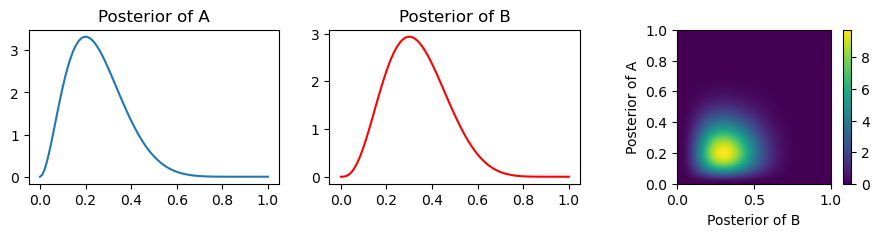

In [45]:
print(a,b,c,d)

k = 100
x = np.linspace(0,1,k)

posteriorA = beta.pdf(x, a,b)
posteriorB = beta.pdf(x, c,d)

joint_posterior = np.zeros( shape=(k, k) ) #The joint posterior is a 2d array
for i in range(k):
    for j in range(k):
        joint_posterior[i,j] = posteriorA[i] * posteriorB[j]

# create a row of 3 plots where the first plot is the posterior of A, the second plot is the posterior of B, and the third plot is the joint posterior
fix,axes = plt.subplots(1,3,figsize=(11,2))
axes[0].plot(x,posteriorA)
axes[0].set_title('Posterior of A')

axes[1].plot(x,posteriorB,'Red');
axes[1].set_title('Posterior of B')

im=axes[2].imshow(joint_posterior, extent=[0,1,0,1], aspect=1, origin='lower')
plt.colorbar(im,ax=axes[2])
axes[2].set_ylabel('Posterior of A')
axes[2].set_xlabel('Posterior of B');

Can you calculate the following probs by taking averages on the 100*100 grid?

In [46]:
errorFunctionA = 0.0
for i in range(100):
    for j in range(i, 100):
        errorFunctionA += joint_posterior[i,j]*0.0001

errorFunctionB = 0.0
for i in range(100):
    for j in range(0,i):
        errorFunctionB += joint_posterior[i,j]*0.0001

print('probability that theta_B > theta_A: ',np.round(errorFunctionA,3))
print('probability that theta_A > theta_B: ',np.round(errorFunctionB,3))

probability that theta_B > theta_A:  0.679
probability that theta_A > theta_B:  0.301


In [137]:
# Computing the loss function
def compute_loss(i, j, var):
    if var == 'A':
        return max(j*0.01 - i*0.01, 0.0)
    if var == 'B':
        return max(i*0.01 - j*0.01, 0.0)

In [139]:
lossFunctionA, lossFunctionB = 0.0, 0.0 
for i in range(100):
    for j in range(100):
        lossFunctionA += joint_posterior[i,j] * compute_loss(i,j,'A')*0.0001
        lossFunctionB += joint_posterior[i,j] * compute_loss(i,j,'B')*0.0001

print(np.round(lossFunctionA,3), np.round(lossFunctionB,3))

0.117 0.036


#### Investigate Sample Size vs Loss

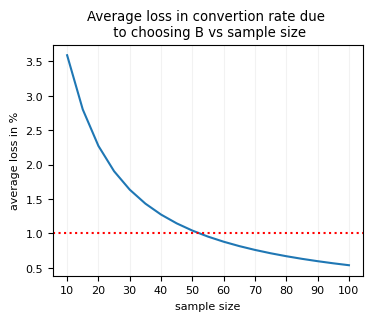

In [144]:
# let's write a function to compute the loss function for different sample sizes and generates a plot where we can see how the average loss changes as a function of the sample size. 

def compute_loss_vs_sample_size(N, success_A, success_B):

    loss = []
    for i in range(10,N+1,5):
        loss.append(compute_avg_loss(i, success_A, success_B))

    return loss


def compute_avg_loss(N, success_A, success_B):

    N_A, N_B = N, N

    a = success_A + 1
    b = N_A - success_A + 1

    c = success_B + 1
    d = N_B - success_B + 1

    posteriorA = beta.pdf(np.linspace(0,1,100), a,b)
    posteriorB = beta.pdf(np.linspace(0,1,100), c,d)

    joint_posterior = np.zeros(shape=(100,100)) 

    for i in range(k):
        for j in range(k):
            joint_posterior[i,j] = posteriorA[i] * posteriorB[j]

    lossFunctionB = 0.0
    for i in range(100):
        for j in range(100):
            lossFunctionB += joint_posterior[i,j] * compute_loss(i,j,'B')*0.0001
    
    return lossFunctionB

# let's plot the loss function as a function of the sample size
loss = compute_loss_vs_sample_size(N=100, success_A=2, success_B=3)

fig = plt.figure(figsize=(4,3))
plt.rcParams.update({'font.size': 8})


plt.plot(np.arange(10,101,5), pd.Series(loss)*100,)
plt.axhline(y=1, color="red", linestyle=':')

plt.xlabel('sample size')
plt.ylabel('average loss in %')
plt.title('Average loss in convertion rate due \n to choosing B vs sample size')
plt.xticks(np.arange(10,101,10))
plt.grid(axis='x', color='0.95')
plt.show()

### PyMC solution
Instead of simulating Beta distributions, we can use PyMC to simulate the posterior distributions of $\theta_A$ and $\theta_B$ and then calculate the probabilities and loss function using the posterior samples.

In [11]:
# Load libraries
import arviz as az
import pymc as pm

In [12]:
with pm.Model() as example_model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = [1,1], 
                    beta  = [1,1], 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n        = [10, 10], 
                      observed = [2, 3], 
                      p        = theta,
                      shape    = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift", 
                                        theta[1] / theta[0] - 1)

    # Draw samples from the prior
    trace = pm.sample(draws=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [13]:
# check the shape of the trace
trace.posterior.uplift.shape

(4, 1000)

In [14]:
pm.summary(trace, var_names=["theta", "uplift"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.249,0.118,0.052,0.479,0.002,0.001,3961.0,2808.0,1.0
theta[1],0.335,0.127,0.111,0.570,0.002,0.002,3534.0,2756.0,1.0
uplift,0.828,1.718,-0.792,3.308,0.031,0.022,3756.0,2842.0,1.0


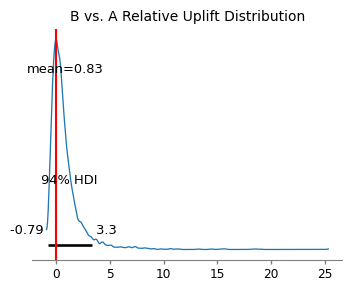

In [15]:
az.plot_posterior(trace.posterior["uplift"], figsize=(4, 3))

plt.title("B vs. A Relative Uplift Distribution", fontsize=10)
plt.axvline(x=0, color="red");

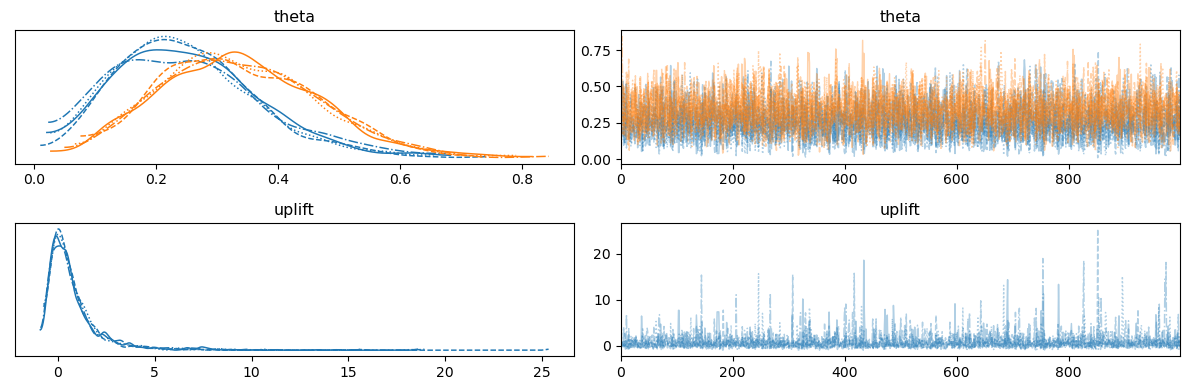

In [16]:
az.plot_trace(trace, compact=True, combined=False)
plt.tight_layout();

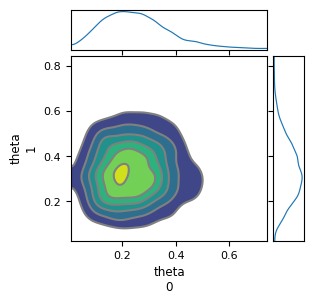

In [17]:
az.plot_pair(trace, var_names=["theta"], kind="kde", marginals=True, textsize=8, figsize=(3, 3));

In [152]:
print('probability that theta_B > theta_A: ', np.mean(trace.posterior.uplift>0).values)

probability that theta_B > theta_A:  0.69675


In [20]:
def ReLU(x):
    return x * (x > 0)

In [146]:
x = trace.posterior.theta[0,:,0] - trace.posterior.theta[0,:,1]
lossFunctionA = np.mean(ReLU(-x).values)
lossFunctionB = np.mean(ReLU(x).values)

print('loss function if A is deployed: ', np.round(lossFunctionA,3))
print('loss function if B is deployed: ', np.round(lossFunctionB,3))

loss function if A is deployed:  0.12
loss function if B is deployed:  0.037
